In [1]:
import argparse
import os
import json
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import torch
from torch.nn import CrossEntropyLoss
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm

import math
import matplotlib.pyplot as plt
from pprint import pprint
import seaborn as sns

from watermarks.kgw.watermark_processor import WatermarkDetector
from watermarks.aar.aar_watermark import AarWatermarkDetector
from watermarks.watermark_types import WatermarkType
from matplotlib import font_manager

fontP = font_manager.FontProperties()
fontP.set_family('SimHei')
fontP.set_size(14)

DEFAULT_PAD_TOKEN = "[PAD]"
DEFAULT_EOS_TOKEN = "</s>"
DEFAULT_BOS_TOKEN = "<s>"
DEFAULT_UNK_TOKEN = "<unk>"

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
# os.environ["CUDA_VISIBLE_DEVICES"]= "1,2,3"

Using device: cpu


/remote-home1/miintern1/anaconda3/envs/watermark/lib/python3.12/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025845206/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


### Intro Graphs

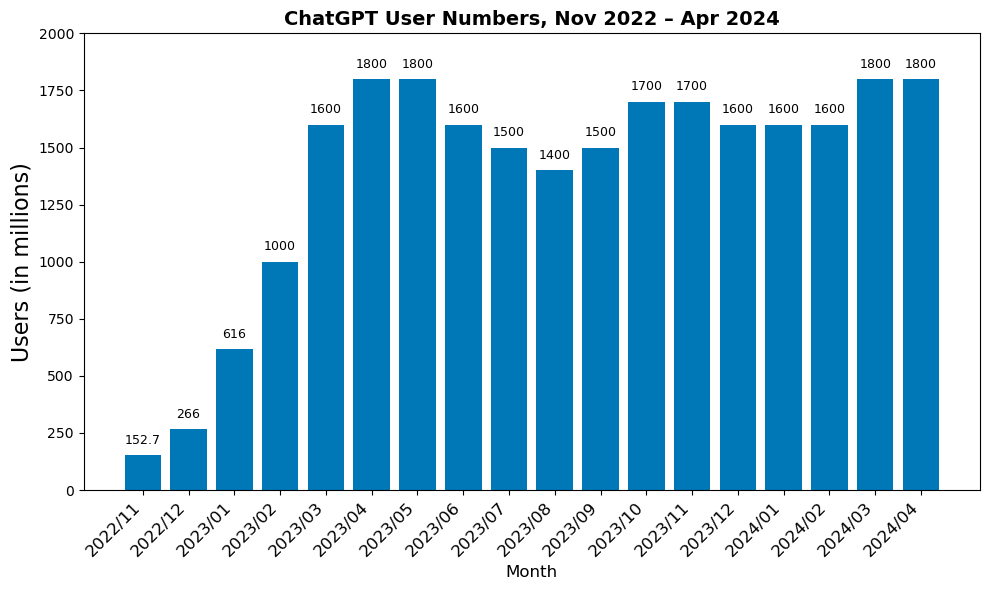

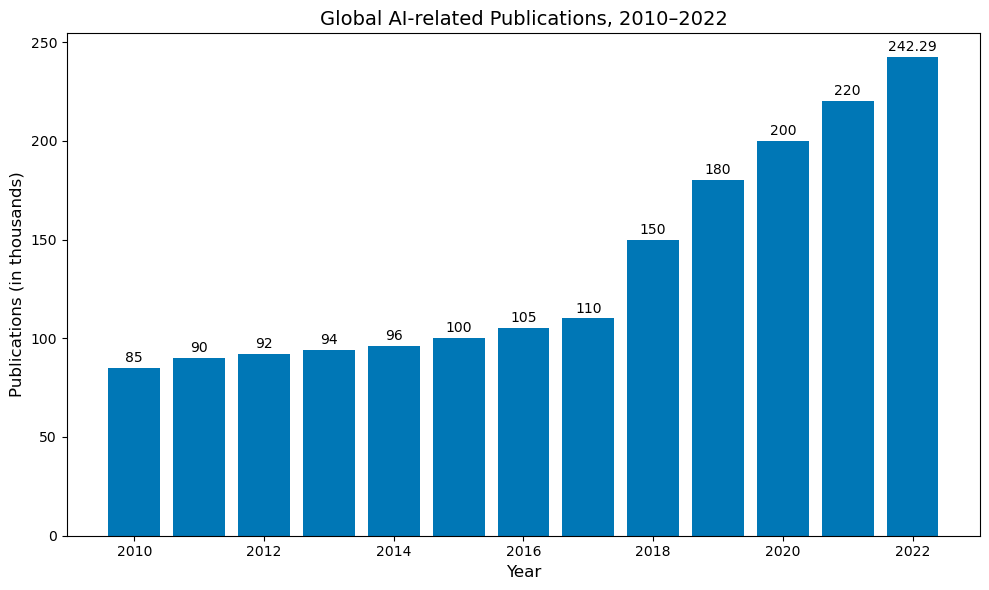

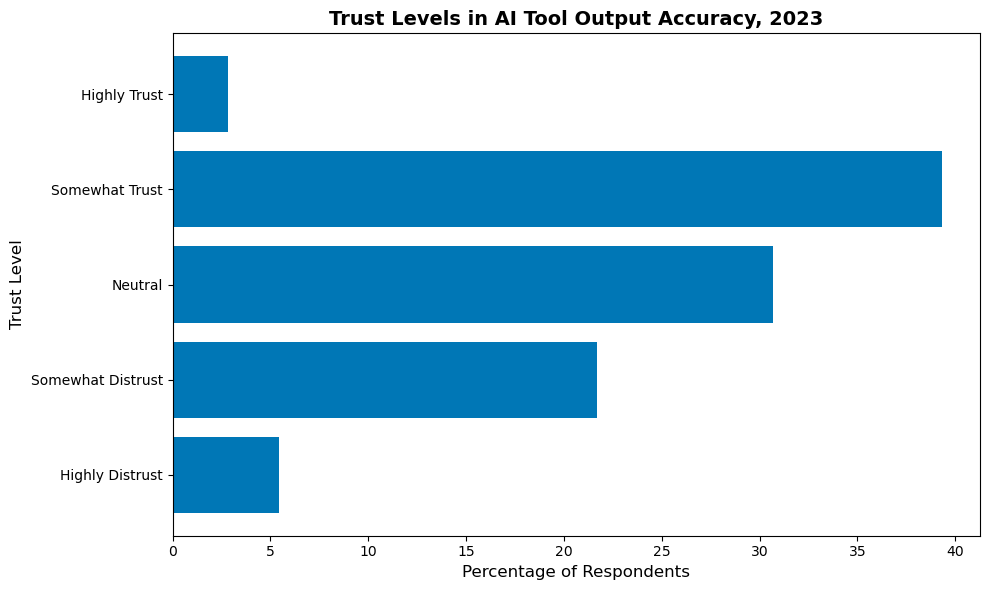

In [3]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Load the SimHei font for Chinese characters
simhei_font = fm.FontProperties(fname='/remote-home/miintern1/watermark-learnability/SimHei.ttf')
simhei_font.set_size(16)

# Data from the provided material
months = [
    "2022/11", "2022/12", "2023/01", "2023/02", "2023/03", 
    "2023/04", "2023/05", "2023/06", "2023/07", "2023/08", 
    "2023/09", "2023/10", "2023/11", "2023/12", "2024/01", 
    "2024/02", "2024/03", "2024/04"
]
users = [
    152.7, 266, 616, 1000, 1600, 
    1800, 1800, 1600, 1500, 1400, 
    1500, 1700, 1700, 1600, 1600, 
    1600, 1800, 1800
]

# Plotting the data
plt.figure(figsize=(10, 6))
plt.bar(months, users, color='#0077B6')

# Formatting the plot to match the given graph style
plt.title("ChatGPT 用户数量, 2022年11月–2024年4月", fontsize=14, weight='bold', fontproperties=simhei_font)
plt.xlabel("月份", fontsize=12, fontproperties=simhei_font)
plt.ylabel("用户数量（百万）", fontsize=16, fontproperties=simhei_font)
plt.xticks(rotation=45, ha='right', fontproperties=simhei_font, fontsize=12)
plt.yticks(fontsize=10, fontproperties=simhei_font)
plt.ylim(0, 2000)

# Add values on top of the bars
for i, value in enumerate(users):
    plt.text(i, value + 50, f"{value}", ha='center', fontsize=9)
# plt.text(0, -400, '数据来源：DemandSage', fontsize=8, ha='left', fontproperties=simhei_font)

plt.tight_layout()
plt.show()


# Data for the chart
years = list(range(2010, 2023))
publications = [85, 90, 92, 94, 96, 100, 105, 110, 150, 180, 200, 220, 242.29]

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(years, publications, color='#0077B6')

# Adding titles and labels in Chinese
plt.title('全球人工智能相关出版物数量，2010–2022年', fontsize=14, fontproperties=simhei_font)
plt.xlabel('年份', fontsize=12, fontproperties=simhei_font)
plt.ylabel('人工智能出版物数量（千篇）', fontsize=12, fontproperties=simhei_font)

# Adding the source and chart info in Chinese
plt.text(2010, -30, '来源：斯坦福安全与新兴技术中心, 2023 | 图表：2024 AI 指数报告', fontsize=8, ha='left', fontproperties=simhei_font)

# Display the values on top of each bar
for i, v in enumerate(publications):
    plt.text(years[i], v + 3, str(v), ha='center')

# Show the plot
# plt.tight_layout()
plt.show()

# Data
categories = [
    '高度不信任', 
    '有些不信任', 
    '无感', 
    '有些信任', 
    '高度信任'
]
# categories = [i for i in range(5,0,-1)]
percentages = [5.46, 21.71, 30.68, 39.30, 2.85]

# Create the horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(categories, percentages, color='#0077B6')

# Adding titles and labels in Chinese
plt.title('2023年对AI工具输出准确性的信任水平', fontsize=14, weight='bold', fontproperties=simhei_font)
plt.xlabel('受访者百分比', fontsize=12, fontproperties=simhei_font)
plt.ylabel('信任水平', fontsize=12, fontproperties=simhei_font)

# Adding the source and chart info in Chinese
plt.yticks(fontsize=12, fontproperties=simhei_font)
# plt.text(-4, -1.2, '来源：Stack Overflow 开发者调查，2023 | 图表：2024 AI 指数报告', fontsize=8, ha='left', fontproperties=simhei_font)

# Adding the percentage values to the bars
# for i, v in enumerate(percentages):
#     plt.text(v + 0.3, i, f"{v}%", ha='left', va='center', fontproperties=simhei_font)

# Show the plot
plt.tight_layout()
plt.show()


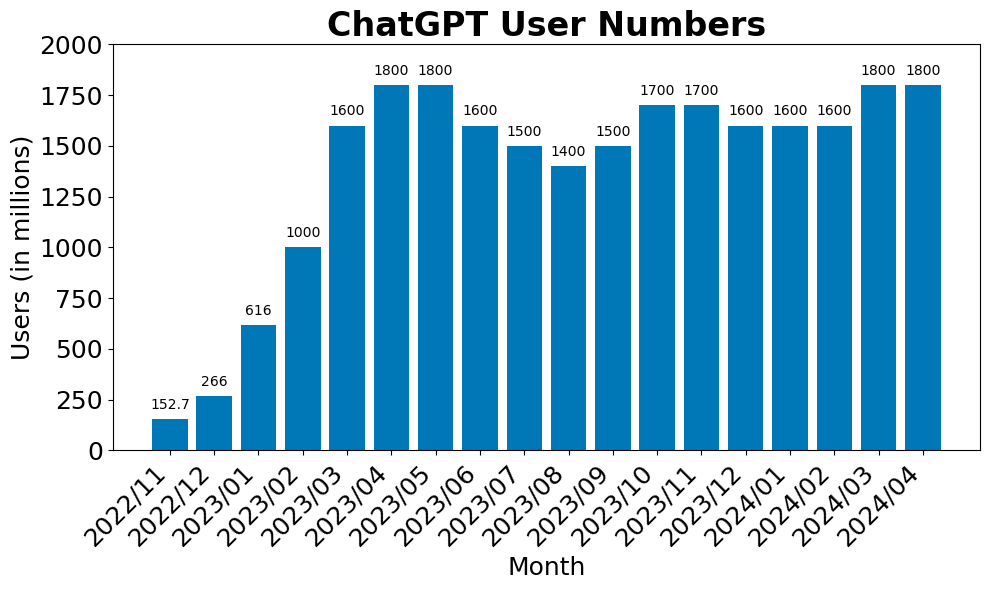

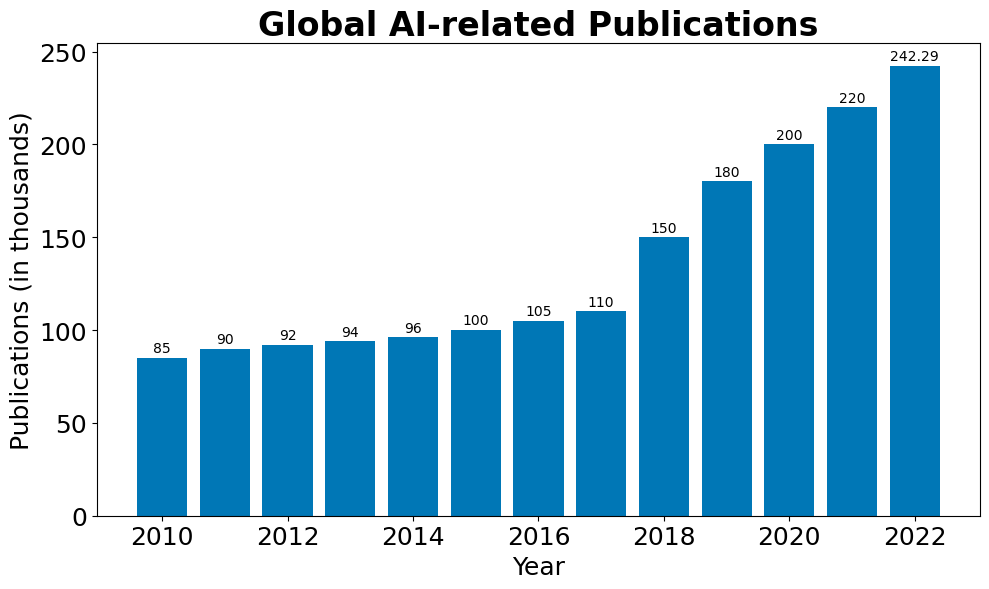

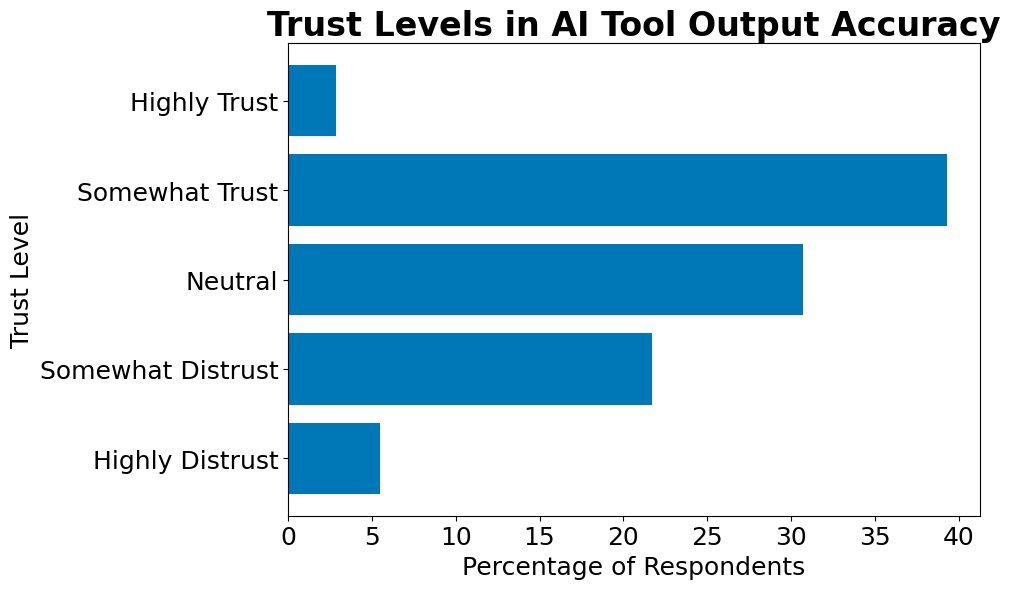

In [17]:
import matplotlib.pyplot as plt

title_fontsize = 24
label_fontsize = 18
# Data from the provided material
months = [
    "2022/11", "2022/12", "2023/01", "2023/02", "2023/03", 
    "2023/04", "2023/05", "2023/06", "2023/07", "2023/08", 
    "2023/09", "2023/10", "2023/11", "2023/12", "2024/01", 
    "2024/02", "2024/03", "2024/04"
]
users = [
    152.7, 266, 616, 1000, 1600, 
    1800, 1800, 1600, 1500, 1400, 
    1500, 1700, 1700, 1600, 1600, 
    1600, 1800, 1800
]

# Plotting the data
plt.figure(figsize=(10, 6))
plt.bar(months, users, color='#0077B6')

# Formatting the plot to match the given graph style
plt.title("ChatGPT User Numbers", fontsize=title_fontsize, weight='bold')
plt.xlabel("Month", fontsize=18)
plt.ylabel("Users (in millions)", fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(0, 2000)

# Add values on top of the bars
for i, value in enumerate(users):
    plt.text(i, value + 50, f"{value}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()


# Data for the chart
years = list(range(2010, 2023))
publications = [85, 90, 92, 94, 96, 100, 105, 110, 150, 180, 200, 220, 242.29]

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(years, publications, color='#0077B6')

# Adding titles and labels in English
plt.title('Global AI-related Publications', fontsize=title_fontsize, weight='bold')
plt.xlabel('Year', fontsize=18)
plt.ylabel('Publications (in thousands)', fontsize=18)

# Display the values on top of each bar
for i, v in enumerate(publications):
    plt.text(years[i], v + 3, str(v), ha='center', fontsize = 10)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.tight_layout()
plt.show()

# Data
categories = [
    'Highly Distrust', 
    'Somewhat Distrust', 
    'Neutral', 
    'Somewhat Trust', 
    'Highly Trust'
]
percentages = [5.46, 21.71, 30.68, 39.30, 2.85]

# Create the horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(categories, percentages, color='#0077B6')

# Adding titles and labels in English
plt.title('Trust Levels in AI Tool Output Accuracy', fontsize=title_fontsize, weight='bold')
plt.xlabel('Percentage of Respondents', fontsize=18)
plt.ylabel('Trust Level', fontsize=18)

# Adjust ticks' font size
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.tight_layout()
plt.show()


In [7]:
import plotly.graph_objects as go
import plotly.express as px

# Data for the first plot
months = [
    "2022/11", "2022/12", "2023/01", "2023/02", "2023/03", 
    "2023/04", "2023/05", "2023/06", "2023/07", "2023/08", 
    "2023/09", "2023/10", "2023/11", "2023/12", "2024/01", 
    "2024/02", "2024/03", "2024/04"
]
users = [
    152.7, 266, 616, 1000, 1600, 
    1800, 1800, 1600, 1500, 1400, 
    1500, 1700, 1700, 1600, 1600, 
    1600, 1800, 1800
]

# Create a bar plot using plotly
fig1 = go.Figure(
    data=[go.Bar(x=months, y=users, text=users, textposition='auto')],
    layout_title_text="ChatGPT User Numbers, Nov 2022 – Apr 2024"
)
fig1.update_layout(
    xaxis_title="Month",
    yaxis_title="Users (in millions)",
    xaxis_tickangle=-45
)

# Data for the second plot
years = list(range(2010, 2023))
publications = [85, 90, 92, 94, 96, 100, 105, 110, 150, 180, 200, 220, 242.29]

# Create a bar plot for global AI-related publications
fig2 = go.Figure(
    data=[go.Bar(x=years, y=publications, text=publications, textposition='auto')],
    layout_title_text="Global AI-related Publications, 2010–2022"
)
fig2.update_layout(
    xaxis_title="Year",
    yaxis_title="Publications (in thousands)"
)

# Data for the third plot
categories = [
    'Highly Distrust', 
    'Somewhat Distrust', 
    'Neutral', 
    'Somewhat Trust', 
    'Highly Trust'
]
percentages = [5.46, 21.71, 30.68, 39.30, 2.85]

# Create a horizontal bar plot for trust levels in AI tool output accuracy
fig3 = go.Figure(
    data=[go.Bar(x=percentages, y=categories, orientation='h', text=percentages, textposition='auto')],
    layout_title_text="Trust Levels in AI Tool Output Accuracy, 2023"
)
fig3.update_layout(
    xaxis_title="Percentage of Respondents",
    yaxis_title="Trust Level"
)

# Show the figures
fig1.show()
fig2.show()
fig3.show()


### Experiment Results(Chinese Ver.)

In [11]:
with open('/remote-home/miintern1/watermark-learnability/data/c4/watermark_strength_evaluation_extension.json','r') as f:
    data = json.load(f)
pprint(f"There are {data.keys()} watermarks")
x_list = list(data[list(data.keys())[0]].keys())
pprint(f"Coefficient range:{x_list}")

('There are '
 "dict_keys(['cygu/llama-2-7b-logit-watermark-distill-kgw-k0-gamma0.25-delta1', "
 "'cygu/llama-2-7b-logit-watermark-distill-kgw-k0-gamma0.25-delta2', "
 "'cygu/llama-2-7b-logit-watermark-distill-kgw-k1-gamma0.25-delta1', "
 "'cygu/llama-2-7b-logit-watermark-distill-kgw-k1-gamma0.25-delta2', "
 "'cygu/llama-2-7b-logit-watermark-distill-kgw-k2-gamma0.25-delta2']) "
 'watermarks')
("Coefficient range:['watermark_config', '1.0', '1.3', '1.6', "
 "'1.9000000000000001', '2.2', '2.5', '2.8000000000000003', "
 "'3.1000000000000005', '3.4000000000000004', '3.7']")


In [15]:
watermarked_score = dict()
vanilla_score = dict()
for model_name, model_data in data.items():
    model_watermarked_scores = []
    model_vanilla_scores = []
    # print(model_data.keys())
    for coefficient, coefficient_data in model_data.items():
        if coefficient == 'watermark_config':
            continue
        watermarked_scores = np.array(coefficient_data['watermarked_scores'])
        vanilla_scores = np.array(coefficient_data['vanilla_scores']) if 'vanilla_scores' in coefficient_data else np.zeros_like(watermarked_scores)
        # print(watermarked_scores.shape)
        watermarked_scores = -np.log(watermarked_scores)
        watermarked_median = np.median(watermarked_scores)
        watermarked_mean = np.mean(watermarked_scores)
        # print(f"{coefficient}: Watermarked median: {watermarked_median}, mean: {watermarked_mean}")
        if 'vanilla_scores' in coefficient_data:
            vanilla_scores = -np.log(vanilla_scores)
            vanilla_median = np.median(vanilla_scores)
            vanilla_mean = np.mean(vanilla_scores)
            model_vanilla_scores.append(vanilla_median)

        model_watermarked_scores.append(watermarked_median)
    watermarked_score[model_name] = model_watermarked_scores
    vanilla_score[model_name] = model_vanilla_scores


/tmp/ipykernel_837926/4098331398.py:13: RuntimeWarning: divide by zero encountered in log
  watermarked_scores = -np.log(watermarked_scores)


In [16]:
watermarked_score_truncated = dict()
for model_name, scores in watermarked_score.items():
    watermarked_score_truncated[model_name] = scores[:11]
watermarked_score_truncated = {'cygu/llama-2-7b-logit-watermark-distill-kgw-k0-gamma0.25-delta1': [0.92044991756426,
  1.1318824525733122,
  1.3209617942328282,
  1.8448287354560908,
  2.8586324840838433,
  3.092495185079766,
  4.034449822201138,
  5.118562973566308,
  6.52444857939852,
  8.114259491110827,
  9.88723036164782],
 'cygu/llama-2-7b-logit-watermark-distill-kgw-k0-gamma0.25-delta2': [0.7218169785440427,
  1.3209617942328282,
  2.267390879411207,
  3.5304639364792383,
  5.566725465740022,
  8.030039343884456,
  11.17047243774299,
  16.030900420732763,
  21.46381255445895,
  28.393311792472733,
  35.10179631544479],
 'cygu/llama-2-7b-logit-watermark-distill-kgw-k1-gamma0.25-delta1': [0.6716473914041593,
  0.8078023024510621,
  0.9610071766729709,
  1.1318824525733122,
  1.5286997273776668,
  1.934177815952967,
  2.267390879411207,
  2.8586324840838433,
  3.5304639364792383,
  4.283642972181978,
  5.566725465740022],
 'cygu/llama-2-7b-logit-watermark-distill-kgw-k1-gamma0.25-delta2': [0.5518285893228358,
  0.8826675684628353,
  1.270236169927872,
  1.7554796549592147,
  2.267390879411207,
  3.5304639364792383,
  5.118562973566308,
  7.5639265050781965,
  10.518751742692956,
  14.730665983202995,
  20.552801680344437]}

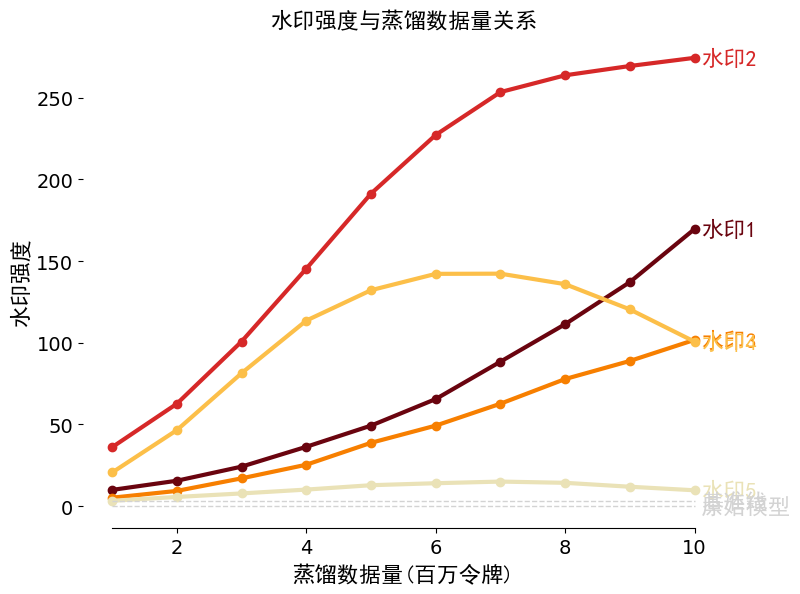

In [18]:
# Set the font properties (ensure the font path is correct)
import matplotlib.font_manager as fm
simhei_font = fm.FontProperties(fname='/remote-home/miintern1/watermark-learnability/SimHei.ttf')
# fontP.set_family('SimHei')
simhei_font.set_size(16)

# Data points

# Plotting
x = list(range(1, 11))  # Assuming 11 points for simplicity
fig, ax = plt.subplots(figsize=(8, 6))
name_list = ["水印1", "水印2", "水印3", "水印4", "水印5"]
color_list = ['#6a040f','#d62828','#f77f00','#fcbf49','#eae2b7']

# ax.plot(x, kgw_y, 'o-', label=name_list[0], color=color_list[0], linewidth=3)
# ax.plot(x, aar_y, 'o-', label=name_list[1], color=color_list[1], linewidth=3)
# ax.plot(x, kth_y, 'o-', label=name_list[2], color=color_list[2], linewidth=3)

# Plot each key-value pair
for i, (key, y_values) in enumerate(watermarked_score.items()):
    ax.plot(x, y_values, 'o-', label=name_list[i], color=color_list[i], linewidth=3)
    ax.text(
        x[-1] * 1.01,
        y_values[-1],
        f'{name_list[i]}',
        color=color_list[i],
        fontweight="bold",
        horizontalalignment="left",
        verticalalignment="center",
        fontproperties=simhei_font
    )

ax.text(
    x[-1] * 1.01,
    3,
    "基准线",
    color="lightgray",
    fontweight="bold",
    horizontalalignment="left",
    verticalalignment="center",
    fontproperties=simhei_font
)

ax.plot(
    [x[0],x[-1]], 
    [3,3], label="基准线",
    color='lightgrey',
    linestyle="--",
    linewidth=1,
)

ax.text(
    x[-1] * 1.01,
    0,
    "原始模型",
    color="lightgray",
    fontweight="bold",
    horizontalalignment="left",
    verticalalignment="center",
    fontproperties=simhei_font
)

ax.plot(
    [x[0],x[-1]], 
    [0,0], label="原始模型",
    color='lightgrey',
    linestyle="--",
    linewidth=1,
)

# Hide all but the bottom spines (axis lines)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.spines["bottom"].set_bounds(min(x), max(x))

plt.title("水印强度与蒸馏数据量关系", fontproperties=simhei_font)
plt.xlabel('蒸馏数据量(百万令牌)', fontproperties=simhei_font)
plt.ylabel('水印强度', fontproperties=simhei_font)
# plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=14)  # Adjust the size here
# plt.legend(prop = simhei_font)
plt.savefig("great.png", dpi=300)
plt.show()


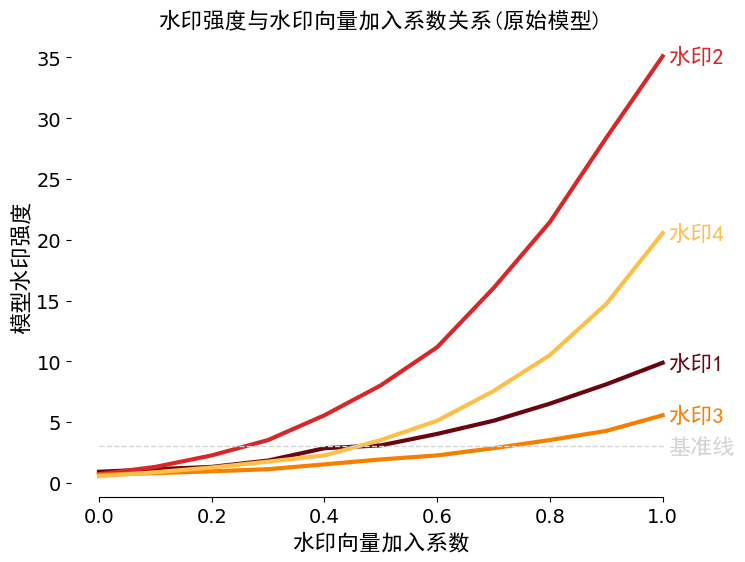

In [19]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
simhei_font = fm.FontProperties(fname='/remote-home/miintern1/watermark-learnability/SimHei.ttf')
# fontP.set_family('SimHei')
simhei_font.set_size(16)


fig, ax = plt.subplots(figsize=(8, 6))
name_list = [f"水印{i}" for i in range(1,10)]
color_list = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
color_list = ['#6a040f','#d62828','#f77f00','#fcbf49','#eae2b7']
# color_list = ['#03045e','#0077b6','#00b4d8','#90e0ef','#caf0f8']
# color_list = ['#ee6055','#60d394','#aaf683','#ffd97d','#ff9b85']
# color_list = ['#ffbe0b','#fb5607','#ff006e','#8338ec','#3a86ff']
x_list = coefficient_list = np.concatenate((np.arange(0.0, 1.0, 0.1) , np.arange(1.0, 4.0, 0.3)))
for i, (model, model_stat) in enumerate(watermarked_score_truncated.items()):
    # x = list(range(len(model_stat['vanilla_score_median'])))
    x = x_list[:len(model_stat)]
    x = x_list[:11]
    ax.plot(x, model_stat[:11], label=f'{name_list[i]}', color=color_list[i], linewidth=3)
    ax.text(
        x[-1] * 1.01,
        model_stat[:11][-1],
        f'{name_list[i]}',
        color=color_list[i],
        fontweight="bold",
        horizontalalignment="left",
        verticalalignment="center",
        fontproperties=simhei_font
    )

ax.text(
    x[-1] * 1.01,
    3,
    "基准线",
    color="lightgray",
    fontweight="bold",
    horizontalalignment="left",
    verticalalignment="center",
    fontproperties=simhei_font
)

ax.plot(
    [x[0],x[-1]], 
    [3,3], label="基准线",
    color='lightgrey',
    linestyle="--",
    linewidth=1,
)

# Hide the all but the bottom spines (axis lines)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.spines["bottom"].set_bounds(min(x), max(x))


plt.title("水印强度与水印向量加入系数关系(原始模型)", fontproperties=simhei_font)
plt.xlabel('水印向量加入系数', fontproperties=simhei_font)
plt.ylabel('模型水印强度', fontproperties=simhei_font)
# plt.grid(True, which="both", ls="--")
# plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=14)  # Adjust the size here
# plt.legend(prop = simhei_font)
# plt.savefig("great.png")
plt.show()


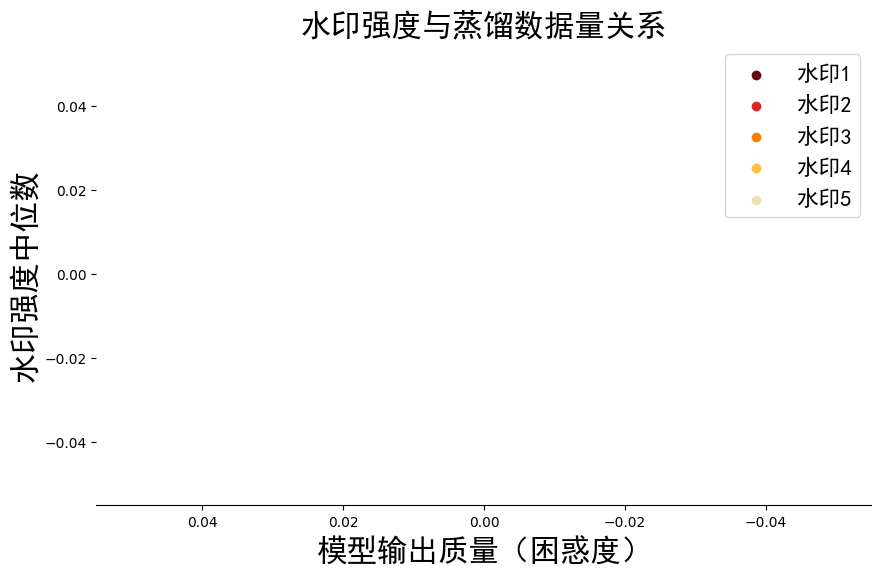

In [20]:
from matplotlib import pyplot as plt

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


# Load the SimHei font for Chinese characters
simhei_font = fm.FontProperties(fname='/remote-home/miintern1/watermark-learnability/SimHei.ttf')
simhei_font.set_size(22)
simhei_font_legend = fm.FontProperties(fname='/remote-home/miintern1/watermark-learnability/SimHei.ttf')
simhei_font_legend.set_size(16)
watermark_name_list = ['水印1', '水印2', '水印3', '水印4', '水印5']
font_path = os.path.abspath('/remote-home/miintern1/watermark-learnability/SimHei.ttf')  # Make sure this path is correct
font_family = "SimHei"
x_list = np.arange(0.0, 1.0, 0.1)

plt.figure(figsize=(10, 6))  # Set the size of the plot
for i, (model, model_stat) in enumerate(data.items()):
    median_ppl = [model_stat[str(x)]['mean_perplexity'] for x in x_list if str(x) in model_stat]
    median_watermark_score = [np.median(-np.log(model_stat[str(x)]['watermarked_scores'])) for x in x_list if str(x) in model_stat]
    
    plt.scatter(median_ppl, median_watermark_score, label=f'{watermark_name_list[i]}', color=color_list[i])
plt.gca().invert_xaxis()
# Add title and labels
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.title('水印强度与蒸馏数据量关系', fontproperties=simhei_font)
plt.xlabel('模型输出质量（困惑度）', fontproperties=simhei_font)
plt.ylabel('水印强度中位数', fontproperties=simhei_font)
# plt.grid(True, which="both", ls="--")

# Set font for legend labels using the prop parameter
plt.legend(prop=simhei_font_legend)

plt.show()

In [ ]:
# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
color_list = ['#6a040f','#d62828','#f77f00','#fcbf49','#eae2b7']

# Iterate over models and plot perplexity
for i, (model, model_stat) in enumerate(data.items()):
    median_ppl = [model_stat.get(str(x), {'mean_perplexity': np.nan})['mean_perplexity'] for x in x_list]
    
    # Print the perplexity values
    print(f"Perplexity values for {model}: {median_ppl}")
    
    # Plot the perplexity values
    ax.plot(x_list, median_ppl, label=f'{model[40:]}', color=color_list[i])

# Add title and labels
plt.title('Median PPL Plot for Watermark Vector (Full)', fontproperties=simhei_font)
plt.xlabel('X轴', fontproperties=simhei_font)  # X-axis label in Chinese
plt.ylabel('困惑度', fontproperties=simhei_font)  # Y-axis label in Chinese
plt.grid(True, which="both", ls="--")
plt.legend(prop=simhei_font)
plt.tight_layout()

plt.show()

NameError: name 'perplexity_dict' is not defined

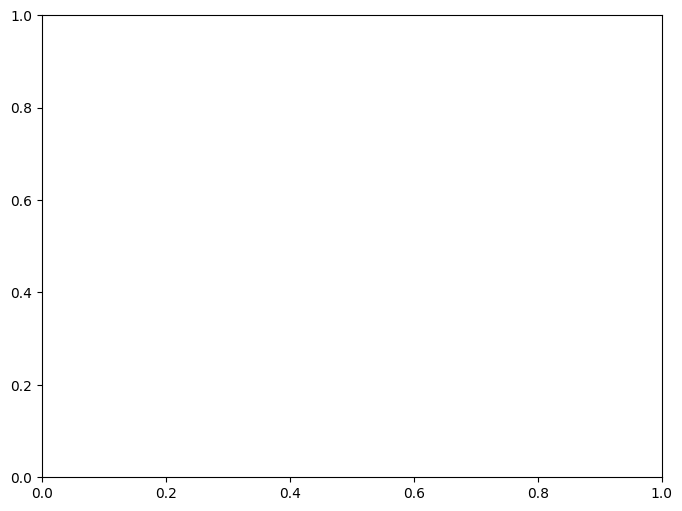

In [12]:
# Plotting
x = list(range(1, 12))  # Assuming 11 points for simplicity
x = x_list[:11]
fig, ax = plt.subplots(figsize=(8, 6))
name_list = ["水印1", "水印2", "水印3", "水印4", "水印5"]
color_list = ['#6a040f','#d62828','#f77f00','#fcbf49','#eae2b7']
baseline = 5.3
original_model_score = 5.6
# ax.plot(x, kgw_y, 'o-', label=name_list[0], color=color_list[0], linewidth=3)
# ax.plot(x, aar_y, 'o-', label=name_list[1], color=color_list[1], linewidth=3)
# ax.plot(x, kth_y, 'o-', label=name_list[2], color=color_list[2], linewidth=3)

# Plot each key-value pair
for i, (key, y_values) in enumerate(perplexity_dict.items()):
    ax.plot(x, y_values, 'o-', label=name_list[i], color=color_list[i], linewidth=3)
    ax.text(
        x[-1] * 1.01,
        y_values[-1],
        f'{name_list[i]}',
        color=color_list[i],
        fontweight="bold",
        horizontalalignment="left",
        verticalalignment="center",
        fontproperties=simhei_font
    )

# ax.text(
#     x[-1] * 1.01,
#     baseline,
#     "基准线",
#     color="lightgray",
#     fontweight="bold",
#     horizontalalignment="left",
#     verticalalignment="center",
#     fontproperties=simhei_font
# )

# ax.plot(
#     [x[0],x[-1]], 
#     [baseline,baseline], label="基准线",
#     color='lightgrey',
#     linestyle="--",
#     linewidth=1,
# )

ax.text(
    x[-1] * 1.01,
    original_model_score,
    "原始模型",
    color="lightgray",
    fontweight="bold",
    horizontalalignment="left",
    verticalalignment="center",
    fontproperties=simhei_font
)

ax.plot(
    [x[0],x[-1]], 
    [original_model_score, original_model_score], label="原始模型",
    color='lightgrey',
    linestyle="--",
    linewidth=1,
)

# Hide all but the bottom spines (axis lines)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.spines["bottom"].set_bounds(min(x), max(x))

plt.title("水印强度与蒸馏数据量关系", fontproperties=simhei_font)
plt.xlabel('蒸馏数据量(百万令牌)', fontproperties=simhei_font)
plt.ylabel('水印强度', fontproperties=simhei_font)

plt.title("模型输出质量与水印向量加入系数关系(同类模型)",fontproperties=simhei_font)
plt.xlabel("水印向量加入系数",fontproperties=simhei_font)
plt.ylabel("文本困惑度",fontproperties=simhei_font)

# plt.grid(True, which="both", ls="--")
# plt.ylim(4,8)
plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=14)  # Adjust the size here
# plt.legend(prop = simhei_font)
plt.savefig("great.png", dpi=300)
plt.show()


In [ ]:
import plotly.graph_objects as go
import numpy as np

# Set the font properties
font_path = os.path.abspath('/remote-home/miintern1/watermark-learnability/SimHei.ttf')  # Make sure this path is correct
font_family = "SimHei"

name_list = [f"水印{i}" for i in range(1, 10)]
color_list = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
x_list = np.concatenate((np.arange(0.0, 1.0, 0.1), np.arange(1.0, 4.0, 0.3)))

fig = go.Figure()

for i, (model, model_stat) in enumerate(watermarked_score.items()):
    x = x_list[:len(model_stat)]
    x = x_list[:11]
    fig.add_trace(go.Scatter(x=x, y=model_stat[:11], mode='lines', name=f'{name_list[i]}', line=dict(color=color_list[i])))

# Add horizontal line
fig.add_hline(y=3, line_dash="dash", line_color="black", annotation_text="可用水印强度", annotation_position="bottom right")

# Customize the layout
fig.update_layout(
    title="水印强度与水印向量加入系数关系(同类模型)",
    xaxis_title="水印向量加入系数",
    yaxis_title="模型水印强度",
    font=dict(family=font_family, size=14),  # Set the font for the entire plot
    legend_title="",
    legend=dict(font=dict(family=simhei_font, size=12)),
    width=800,
    height=600
)

# Show the plot
fig.show()
fig.write_image("test.png")